In [44]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from tqdm import tqdm
import torch
sys.path.append('../')
from plane import Plane
from propagator import PropagatorFactory

In [4]:
config = yaml.load(open('../config.yaml', 'r'), Loader=yaml.FullLoader)

In [116]:
plane1_params = {
    'name':'input_plane',
    'size': (5.e-3, 5.e-3),
    'Nx':166,
    'Ny':166,
    'center': (0,0,0),
    'normal': (0,0,1)
}
plane2_params = {
    'name':'output_plane',
    'size': (5.e-3, 5.e-3),
    'Nx':166,
    'Ny':166,
    'center': (0,0,9.e-2),
    'normal': (0,0,1)
}

In [117]:
plane1 = Plane(plane1_params)
plane2 = Plane(plane2_params)

2024-02-13 18:57:23.231 | DEBUG    | plane:__init__:8 - Initializing plane input_plane
2024-02-13 18:57:23.233 | DEBUG    | plane:fix_types:31 - Fixing types for plane input_plane
2024-02-13 18:57:23.237 | DEBUG    | plane:create_rotation_matrix:80 - Creating rotation matrix
2024-02-13 18:57:23.238 | DEBUG    | plane:create_rotation_matrix:93 - Input and output plane normals are the same.
2024-02-13 18:57:23.240 | DEBUG    | plane:build_plane:41 - Building plane input_plane
2024-02-13 18:57:23.243 | DEBUG    | plane:__init__:8 - Initializing plane output_plane
2024-02-13 18:57:23.244 | DEBUG    | plane:fix_types:31 - Fixing types for plane output_plane
2024-02-13 18:57:23.246 | DEBUG    | plane:create_rotation_matrix:80 - Creating rotation matrix
2024-02-13 18:57:23.248 | DEBUG    | plane:create_rotation_matrix:93 - Input and output plane normals are the same.
2024-02-13 18:57:23.249 | DEBUG    | plane:build_plane:41 - Building plane output_plane


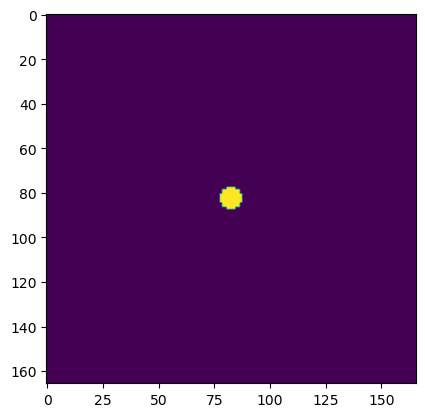

In [118]:
U = torch.ones((plane1.Nx, plane1.Ny))
mask = np.sqrt(plane1.xx**2 + plane1.yy**2) < 0.15e-3
U = U * mask
plt.imshow(U)

In [119]:
pf = PropagatorFactory()
prop = pf(plane1, plane2, config)

2024-02-13 18:57:24.811 | DEBUG    | propagator:select_propagator:21 - Selecting propagator
2024-02-13 18:57:24.813 | DEBUG    | propagator:check_asm_distance:131 - Checking ASM propagation criteria
2024-02-13 18:57:24.815 | DEBUG    | propagator:check_asm_distance:144 - Axial distance between input and output planes: 0.09000000357627869
2024-02-13 18:57:24.818 | DEBUG    | propagator:check_asm_distance:153 - Maximum axial distance for asm : 0.19668972492218018
2024-02-13 18:57:24.819 | DEBUG    | propagator:select_propagator:66 - Using ASM propagator
2024-02-13 18:57:24.821 | DEBUG    | propagator:init_asm_transfer_function:158 - Initializing ASM transfer function


In [120]:
output = prop(U)

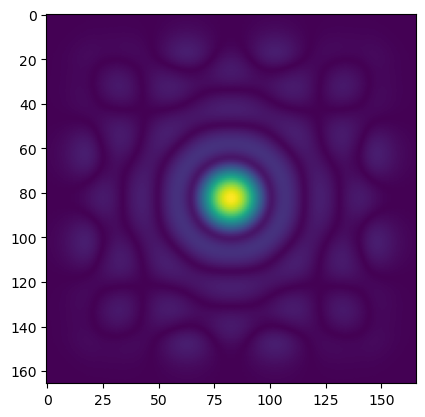

In [121]:
plt.imshow(output.abs())

In [134]:
distance = plane2.center[-1] - plane1.center[-1]
wavelength = 1.55e-6
k = torch.pi * 2 / wavelength
shape = U.size()
padding = (shape[0]//2, shape[0]//2, shape[1]//2, shape[1]//2)
U = torch.nn.functional.pad(U,padding,mode="constant")
output_field = U.new_empty(U.size(), dtype=torch.complex64)

for i,x in enumerate(tqdm(plane1.x)):
    for j,y in enumerate(plane1.y):
        r = torch.sqrt((plane2.xx-x)**2 + (plane2.yy-y)**2 + distance**2)
        chirp = torch.exp(1j * k * r)
        scalar1 = distance / r
        scalar2 = (( 1 / r) - 1j*k)
        combined = U * chirp * scalar1 * scalar2
        output_field[i,j] = combined.sum()

  0%|                                                                                                                                                                                                                 | 0/166 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (332) must match the size of tensor b (166) at non-singleton dimension 1